In [ ]:
!pip install yfinance

     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 6.4 MB 10.2 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm #linear regression model - cointegration and unit root regression
import scipy.optimize as spop #optimise parameters of cointegrating equation, dynamic equilibrium statisfied with highest probability possible
import matplotlib.pyplot as plt 

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#specific parameters
stocks = ['JPM', 'C']
start = '2019-12-31'
end = '2021-04-08'
fee = 0.001
window = 252 #how far back do we look for our cointegration estimation... first model year end 2020 for 1 year + two months to trade based on updating cointegration models... (to include most relevant data)
t_threshold = -2.5 #unit root test. t statistic which is reliable to trade upon... the more negative it is, the better. Less than -2.5 we trade, more we don't

#retrive data from yahoo finance
data = pd.DataFrame()
returns = pd.DataFrame()

for stock in stocks:
    prices = yf.download(stock, start, end)
    data[stock] = prices['Close']
    returns[stock] = np.append(data[stock][1:].reset_index(drop=True)/data[stock][:-1].reset_index(drop=True) - 1,0) #calculate returns properly... length is the same as stock DataFrame
    #to calculate daily returns, you want to be dividing (n+1)th day by nth day (day after today divided by day today to find that day's gain)
print(data['JPM'].head(4))
print(data['JPM'][1:].reset_index(drop=True))
print(data['JPM'][:-1].reset_index(drop=True))
print(data['JPM'][1:].reset_index(drop=True) / data['JPM'][:-1].reset_index(drop=True) - 1)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date
2019-12-31    139.399994
2020-01-02    141.089996
2020-01-03    138.339996
2020-01-06    138.229996
Name: JPM, dtype: float64
0      141.089996
1      138.339996
2      138.229996
3      135.880005
4      136.940002
          ...    
313    152.229996
314    153.710007
315    153.619995
316    152.539993
317    154.929993
Name: JPM, Length: 318, dtype: float64
0      139.399994
1      141.089996
2      138.339996
3      138.229996
4      135.880005
          ...    
313    154.479996
314    152.229996
315    153.710007
316    153.619995
317    152.539993
Name: JPM, Length: 318, dtype: float64
0      0.012123
1     -0.019491
2     -0.000795
3     -0.017001
4      0.007801
         ...   
313   -0.014565
314    0.009722
315   -0.000586
316   -0.007030
317    0.015668
Name: JPM, Length: 318, dtype: float64


day2020-12-30 00:00:00

no trading
gross daily return: 0%
daily net return: 0.0%
cummulative net return so far :0.0%

day2020-12-31 00:00:00

no trading
gross daily return: 0%
daily net return: 0.0%
cummulative net return so far :0.0%

day2021-01-04 00:00:00

no trading
gross daily return: 0%
daily net return: 0.0%
cummulative net return so far :0.0%

day2021-01-05 00:00:00

no trading
gross daily return: 0%
daily net return: 0.0%
cummulative net return so far :0.0%

day2021-01-06 00:00:00

no trading
gross daily return: 0%
daily net return: 0.0%
cummulative net return so far :0.0%

day2021-01-07 00:00:00

no trading
gross daily return: 0%
daily net return: 0.0%
cummulative net return so far :0.0%

day2021-01-08 00:00:00

no trading
gross daily return: 0%
daily net return: 0.0%
cummulative net return so far :0.0%

day2021-01-11 00:00:00

no trading
gross daily return: 0%
daily net return: 0.0%
cummulative net return so far :0.0%

day2021-01-12 00:00:00

long position on JPM short posit

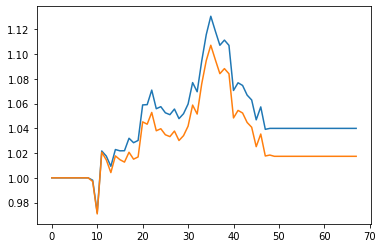

In [ ]:
#initialising arrays
gross_returns = np.array([])
net_returns = np.array([])
t_s = np.array([])

stock1 = stocks[0] #JPM
stock2 = stocks[1] #C

#moving through sample
for t in range(window, len(data)):
    #defining the unit root function: stock2 = a + b*stock1 which we will use for the cointegration
    def unit_root(b):

        #calculate the average of stock2 - b*stock1 (a)
        a = np.average(data[stock2][t-window:t] - b*data[stock1][t-window:t])

        #calculate fair value of stock 2 using stock 1 prices, and parameters 'a' and 'b' we found and assume
        fair_value = a + b*data[stock1][t-window:t]

        #deviation from fair value
        diff = np.array(fair_value - data[stock2][t-window:t])

        #estimate how convergent this equilibrium based on assumed value of b and calculated value of a
        diff_diff = diff[1:] - diff[:-1] #subtract from differences in day 2 up until the end
        
        reg = sm.OLS(diff_diff, diff[:-1]) #diff[:-1] = lagged difference

        #result of regression equation by fitting
        res = reg.fit()

        #return the output of the unit root function (Dick Fuller T Stat, first coefficient of the regression model)
        return res.params[0]/res.bse[0] #bse = SE standard error, zeroth corresponds to standard error of zeroth coefficient
  
    #we need to vary b parameter to minimise t stat, as negative as possible using scipy.optimize package
    #specify optimisation result
    res1 = spop.minimize(unit_root, data[stock2][t]/data[stock1][t], method='Nelder-Mead')
    #optimal t stat = value of the function obtained by minimising  the res1 task
    t_opt = res1.fun #value of the function that's minimal

    #optimal b value from stock2 = a + b*stock1
    b_opt = float(res1.x) #float() because x can be an array made up of different functions
    
    #optimal value of a
    a_opt = np.average(data[stock2][t-window:t] - b_opt*data[stock1][t-window:t])

    #calculate fair value of stock2 at time t
    fair_value = a_opt + b_opt*data[stock1][t]


    #optimising the cointegration equation parameters
    if t == window:
        old_signal  = 0
    if t_opt > t_threshold:
        signal = 0
        gross_return = 0 #we sit in cash if optimal t is greater than threshold t value
    else: 
      signal = np.sign(fair_value - data[stock2][t]) #positive if stock2 undervalued, long 2, short 1
      gross_return = signal*returns[stock2][t] - signal*returns[stock1][t]
  
  #Calculation of Fees:
  #don't change strategy --> no fees
  #sitting in cash, take position --> pay fees once
  #close current positions, then go short/long --> pay fees twice

    fees = fee*abs(signal - old_signal)
    net_return = gross_return - fees
    gross_returns = np.append(gross_returns, gross_return)
    net_returns = np.append(net_returns, net_return)
    t_s = np.append(t_s, t_opt)


    #Simulate Trading
    #trading day printed
    print('day' + str(data.index[t]))
    print('')
    if signal == 0:
      print('no trading')
  
    elif signal == 1:
      print('long position on ' + stocks[1] + ' short position on '+stocks[0])
    
    else:
      print('long position on ' + stocks[0] + ' short position on '+stocks[1])

    print('gross daily return: ' + str(round(gross_return*100,2)) + '%')
    print('daily net return: '+ str(round(net_return*100,2)) + '%')
    print('cummulative net return so far :'+str(round(np.prod(1+net_returns)*100-100,2)) + '%')
    print('')
    old_signal = signal


#plot equity curves
plt.plot(np.append(1, np.cumprod(1+gross_returns)))
plt.plot(np.append(1, np.cumprod(1+net_returns)))